## Import và Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision import models, transforms,datasets
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import random

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


## Data Augmentation

In [2]:
img_height, img_width = 400, 400 

data_transforms = {
    'train': transforms.Compose([
        # Resize ảnh về kích thước cố định
        # Dùng BILINEAR để giữ biên mượt, không tạo artifact mạnh
        transforms.Resize(
            (img_height, img_width),
            interpolation=InterpolationMode.BILINEAR
        ),

        # Flip
        transforms.RandomHorizontalFlip(p=0.5), #  Lật ngang
        transforms.RandomVerticalFlip(p=0.5),  # Lật dọc

        # Affine = rotation + shift + zoom
        transforms.RandomAffine(
            degrees=10,                      # Xoay ±10°
            translate=(0.05, 0.05),           # Dịch ngang/dọc tối đa 5%
            scale=(0.95, 1.05),             # Zoom in/out ±5%
            shear=0,                         # Không shear → tránh méo cấu trúc bệnh
            interpolation=InterpolationMode.BILINEAR,
            fill=0                            # Pixel trống = đen
        ),

        # Brightness
        transforms.ColorJitter(
            brightness=0.1                  # brightness_range=[0.9,1.1]
        ),

        # Tensor + Normalize
        transforms.ToTensor(),              # = rescale 1/255
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
}


## Load Data 

In [3]:
data_dir = '/kaggle/input/bean-leaf-lesions-classification'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}

train_loader = dataloaders['train']
val_loader = dataloaders['val']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx  

print(f"Classes: {class_names}")
print(f"Số lượng ảnh Train: {dataset_sizes['train']}")
print(f"Số lượng ảnh Val: {dataset_sizes['val']}")

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Số lượng ảnh Train: 1034
Số lượng ảnh Val: 133


##  Build Model 

In [4]:
class VGGBlock(nn.Module):
    """
    Block cơ bản của VGG: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
    """
    def __init__(self, in_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.pool(x)
        return x

class BeanLeafVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(BeanLeafVGG, self).__init__()
        
        # Kiến trúc dạng phễu: Tăng chiều sâu (channels), giảm kích thước không gian (spatial size)
        # Input: 3 x 400 x 400
        
        # Block 1: 64 filters (Output: 200x200)
        self.block1 = VGGBlock(3, 32) 
        
        # Block 2: 64 filters (Output: 100x100)
        self.block2 = VGGBlock(32, 64)
        
        # Block 3: 128 filters (Output: 50x50)
        self.block3 = VGGBlock(64, 128)
        
        # Block 4: 256 filters (Output: 25x25)
        self.block4 = VGGBlock(128, 256)
        
        # Block 5: 512 filters (Output: 12x12)
        self.block5 = VGGBlock(256, 512)
        
        # Classifier
        # Thay thế lớp FC khổng lồ của VGG gốc bằng Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Khởi tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BeanLeafVGG(num_classes=3).to(device)

# Kiểm tra số lượng tham số
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Tổng số tham số model: {total_params:,}")

Tổng số tham số model: 4,715,747


## Early Stopping 

In [5]:
# EARLY STOPPING
class EarlyStopping: 
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        # Epoch đầu tiên 
        if self.best_score is None:
            self.best_score = score 
            self.save_checkpoint(val_loss, model)
            
        # Score hiện tại KHÔNG tốt hơn best
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        # Score hiện tại TỐT HƠN best
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## CONFIG Optimizer

In [6]:
# LOSS FUNCTION : CrossEntropyLoss với Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# OPTIMIZER:  AdamW = Adam + decoupled weight decay
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.02) 

# LEARNING RATE SCHEDULER
scheduler = OneCycleLR(optimizer, max_lr=2e-3,    # Learning rate lớn nhất (đỉnh chu kỳ)
                       epochs=80,                    # Tổng số epoch train
                       steps_per_epoch=len(train_loader),  # Số step mỗi epoch
                       pct_start=0.3)    # 30% đầu dùng để warm-up LR

## Training Functions

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        # -----------------
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(all_labels)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, all_preds, all_labels

## Training Loop

In [8]:
# Khởi tạo Early Stopping
early_stopping = EarlyStopping(patience=15, verbose=True, path='best_model.pth')

# Lưu trữ metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

NUM_EPOCHS=80

print("=" * 60)
print("BẮT ĐẦU HUẤN LUYỆN")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scheduler,device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered!")
        break

print("\n" + "=" * 60)
print("HOÀN THÀNH HUẤN LUYỆN")
print("=" * 60)

BẮT ĐẦU HUẤN LUYỆN

Epoch 1/80
----------------------------------------
Train Loss: 0.9080 | Train Acc: 0.6267
Val Loss:   0.9579 | Val Acc:   0.5414
Validation loss decreased (inf → 0.957916). Saving model...

Epoch 2/80
----------------------------------------
Train Loss: 0.8038 | Train Acc: 0.7147
Val Loss:   0.8625 | Val Acc:   0.7218
Validation loss decreased (0.957916 → 0.862481). Saving model...

Epoch 3/80
----------------------------------------
Train Loss: 0.7765 | Train Acc: 0.7282
Val Loss:   0.7007 | Val Acc:   0.7594
Validation loss decreased (0.862481 → 0.700719). Saving model...

Epoch 4/80
----------------------------------------
Train Loss: 0.7236 | Train Acc: 0.7437
Val Loss:   0.7142 | Val Acc:   0.7820
EarlyStopping counter: 1/15

Epoch 5/80
----------------------------------------
Train Loss: 0.7266 | Train Acc: 0.7602
Val Loss:   0.8310 | Val Acc:   0.7820
EarlyStopping counter: 2/15

Epoch 6/80
----------------------------------------
Train Loss: 0.7370 | Train 

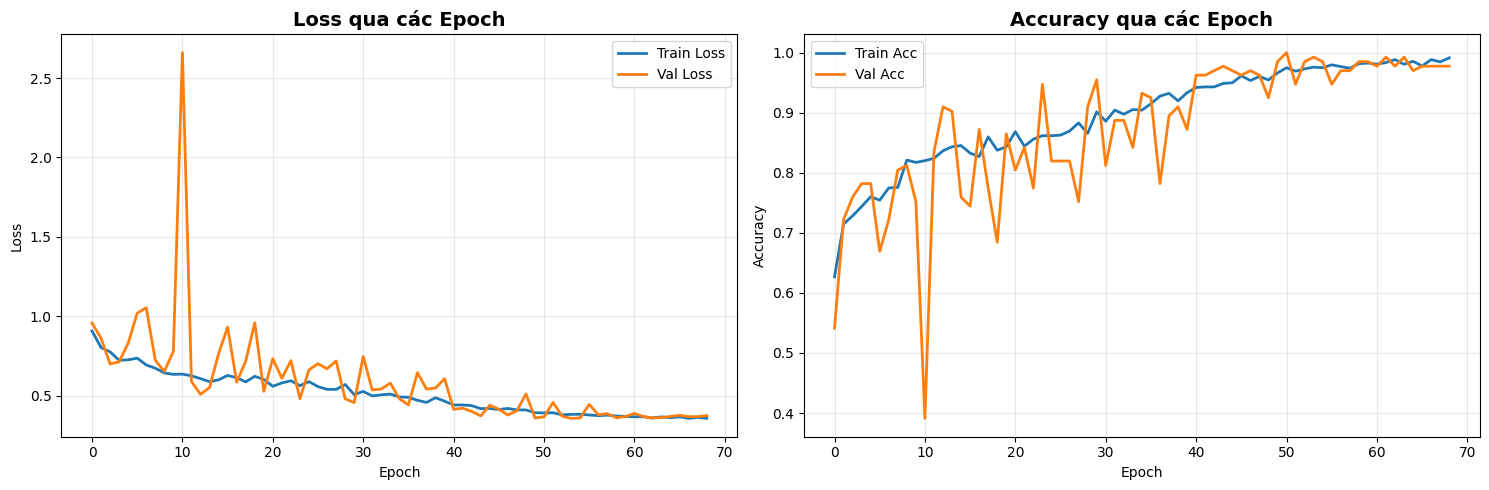

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss qua các Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', linewidth=2)
axes[1].set_title('Accuracy qua các Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Đánh giá

Best model loaded!

VALIDATION SET - CLASSIFICATION REPORT
                   precision    recall  f1-score   support

angular_leaf_spot       1.00      1.00      1.00        44
        bean_rust       1.00      0.98      0.99        45
          healthy       0.98      1.00      0.99        44

         accuracy                           0.99       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.99      0.99      0.99       133



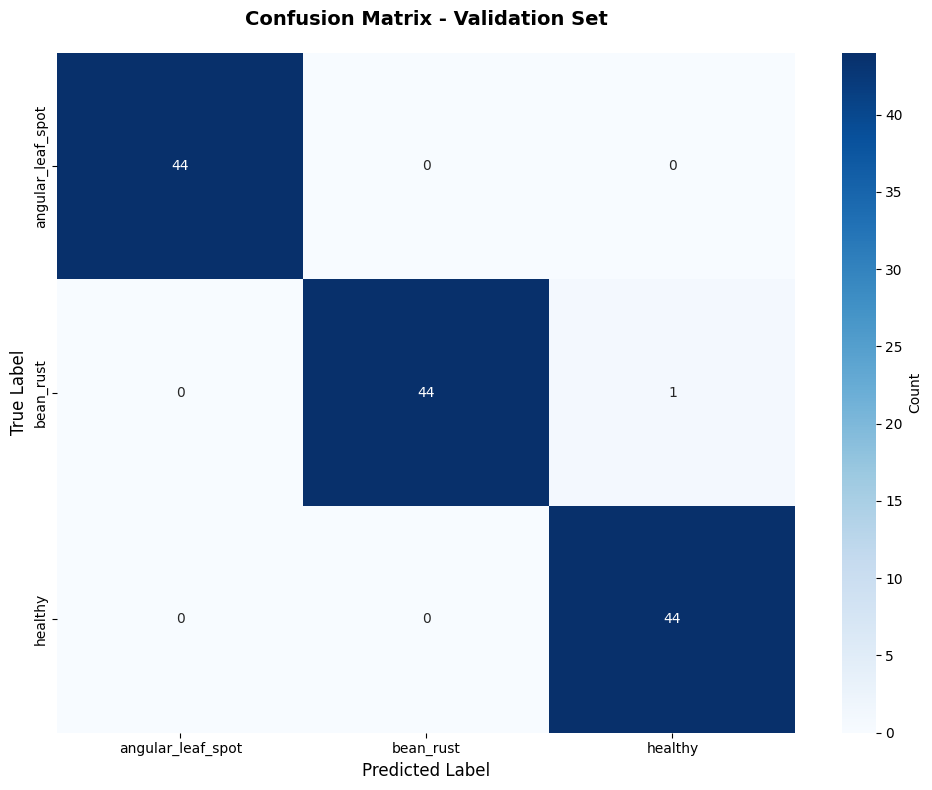

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("Best model loaded!\n")

# Đánh giá trên Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("=" * 60)
print("VALIDATION SET - CLASSIFICATION REPORT")
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=list(class_to_idx.keys()),
    digits=2
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-t2qviquq
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-t2qviquq
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=3dabd9f9d258f4d5d122a86409cb793c0658bd4b37d08c34ba59105b57569e2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-73xdoeui/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


Đã load thành công model từ: best_model.pth
Đang tìm ảnh đại diện cho từng lớp bệnh...


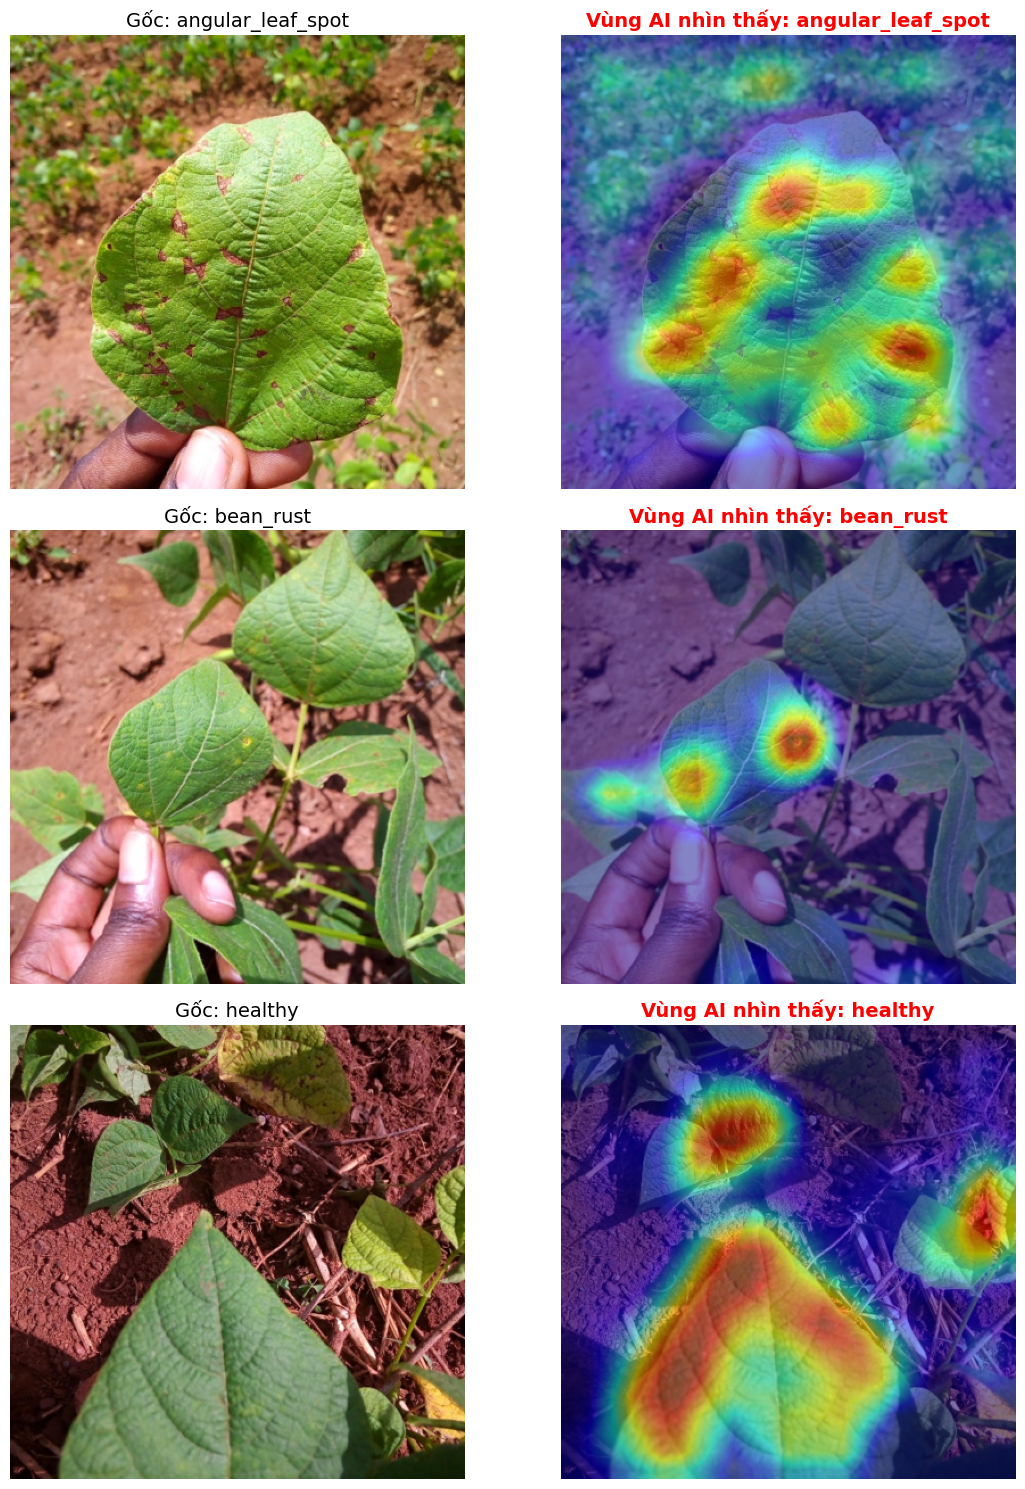

In [12]:
# GRADCAM: HIỂN THỊ VÙNG BỆNH MÔ HÌNH TẬP TRUNG NHÌN VÀO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

def visualize_bean_leaf_gradcam(model, dataset, device):
    """
    Hàm hiển thị GradCAM cho bài toán Bean Leaf Lesions
    """
    model.eval()
    
    # Định nghĩa các lớp cần tìm (0: angular_leaf_spot, 1: bean_rust, 2: healthy)
    required_labels = {0, 1, 2}
    found_indices = {}
    
    print("Đang tìm ảnh đại diện cho từng lớp bệnh...")
    
    # Duyệt ngẫu nhiên hoặc tuần tự để tìm đủ 1 ảnh cho mỗi lớp
    # Dùng try-except để xử lý các loại dataset khác nhau
    limit = min(len(dataset), 1000)
    for i in range(limit):
        try:

            data_item = dataset[i]
            if len(data_item) == 2:
                _, label = data_item
            elif len(data_item) == 3:
                _, _, label = data_item 
            
            # Xử lý label về dạng int
            if isinstance(label, torch.Tensor):
                label_idx = label.item()
            else:
                label_idx = int(label)
                
            if label_idx in required_labels and label_idx not in found_indices:
                found_indices[label_idx] = i
                
            if len(found_indices) == 3: # Đã tìm đủ 3 lớp
                break
        except Exception as e:
            continue

    if len(found_indices) == 0:
        print(" Lỗi: Không tìm thấy ảnh trong dataset.")
        return

    # Lấy tên class chuẩn
    class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

    # Thiết lập biểu đồ
    fig, axes = plt.subplots(nrows=len(found_indices), ncols=2, figsize=(12, 5 * len(found_indices)))
    
    target_layers = []
    if hasattr(model, 'block5'):
        # VGGBlock có conv2 là lớp conv cuối cùng trước khi pool
        target_layers = [model.block5.conv2]
    elif hasattr(model, 'block4'):
        target_layers = [model.block5.conv2]
    elif hasattr(model, 'features'):
        target_layers = [model.features[-1]] # Cho VGG/MobileNet
    elif hasattr(model, 'layer4'):
        target_layers = [model.layer4[-1]] # Cho ResNet
    else:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layers = [module]

    # Khởi tạo GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Các thông số Normalize của ImageNet 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])


    for row_idx, (label_idx, index) in enumerate(sorted(found_indices.items())):
        # Lấy ảnh
        data_item = dataset[index]
        img_tensor = data_item[0] # Giả định phần tử đầu tiên luôn là ảnh
        
        class_name = class_names[label_idx]
        
        # --- Chạy GradCAM ---
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(label_idx)]
        
        # Tạo mask grayscale
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # --- Denormalize ảnh để hiển thị màu gốc ---
        # Chuyển từ Tensor [C, H, W] sang Numpy [H, W, C]
        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
        # Công thức: img * std + mean
        rgb_img = rgb_img * std + mean
        rgb_img = np.clip(rgb_img, 0, 1) # Đảm bảo pixel trong khoảng [0, 1]
        
        # --- Chồng Heatmap lên ảnh ---
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Hiển thị lên subplot
        ax_orig = axes[row_idx][0] if len(found_indices) > 1 else axes[0]
        ax_cam = axes[row_idx][1] if len(found_indices) > 1 else axes[1]
        
        ax_orig.imshow(rgb_img)
        ax_orig.set_title(f"Gốc: {class_name}", fontsize=14)
        ax_orig.axis('off')
        
        ax_cam.imshow(visualization)
        ax_cam.set_title(f"Vùng AI nhìn thấy: {class_name}", fontsize=14, color='red', fontweight='bold')
        ax_cam.axis('off')

    plt.tight_layout()
    plt.show()

model =  BeanLeafVGG(num_classes=3).to(device)
checkpoint_path = 'best_model.pth' 
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Đã load thành công model từ: {checkpoint_path}")
else:
    if os.path.exists('best_model_fold1.pth'):
        model.load_state_dict(torch.load('best_model_fold1.pth'))
        print("Đã load model từ best_model_fold1.pth")
    else:
        print("Cảnh báo: Không tìm thấy file checkpoint nào!")

visualize_bean_leaf_gradcam(model, image_datasets['val'], device)

In [13]:
import os
import numpy as np
import torch
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import datasets, transforms
from tqdm import tqdm 

def save_dataset_gradcams(model, dataset, device, base_output_dir, subset_name):
    """
    Hàm chạy GradCAM và lưu ảnh.
    - subset_name: 'train' hoặc 'val' để đặt tên thư mục con.
    """
    model.eval()
    
    # Đường dẫn lưu: gradcam_results/train hoặc gradcam_results/val
    output_dir = os.path.join(base_output_dir, subset_name)
    
    class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']
    
    # Tạo thư mục theo class
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
            
    print(f"\n>>> Đang xử lý tập: {subset_name.upper()} ({len(dataset)} ảnh)")
    print(f"    Lưu tại: {output_dir}")

    # Tự động tìm target layer (Layer tích chập cuối cùng)
    target_layers = []
    if hasattr(model, 'block5'): target_layers = [model.block5.conv2]  
    elif hasattr(model, 'block4'): target_layers = [model.block4.conv2]
    elif hasattr(model, 'features'): target_layers = [model.features[-1]]
    elif hasattr(model, 'layer4'): target_layers = [model.layer4[-1]]
    else:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layers = [module]

    # Khởi tạo GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Thông số Normalize (ImageNet standard)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Duyệt qua dataset với thanh tiến trình
    for i in tqdm(range(len(dataset)), desc=f"Running {subset_name}"):
        try:
            # Lấy dữ liệu
            data_item = dataset[i]
            img_tensor = data_item[0]
            label = data_item[1]

            if isinstance(label, torch.Tensor):
                label_idx = label.item()
            else:
                label_idx = int(label)
            
            class_name = class_names[label_idx]

            # --- GradCAM Core ---
            input_tensor = img_tensor.unsqueeze(0).to(device)
            targets = [ClassifierOutputTarget(label_idx)] # Soi vào label thực tế

            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # --- Xử lý ảnh để lưu ---
            # Denormalize để lấy lại màu gốc
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = rgb_img * std + mean
            rgb_img = np.clip(rgb_img, 0, 1)
            
            # Chồng heatmap lên ảnh gốc
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            # Lưu ảnh
            save_path = os.path.join(output_dir, class_name, f"{subset_name}_{i:04d}.jpg")
            Image.fromarray(visualization).save(save_path)

        except Exception as e:
            continue

# Load Model
model = BeanLeafVGG(num_classes=3).to(device)
checkpoint_path = 'best_model.pth'

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Đã load model: {checkpoint_path}")
elif os.path.exists('best_model_fold1.pth'):
    model.load_state_dict(torch.load('best_model_fold1.pth'))
    print("Đã load model: best_model_fold1.pth")
else:
    print("Cảnh báo: Không tìm thấy checkpoint nào!")

# Tạo lại Dataset để đảm bảo dùng Transform chuẩn (Resize + Normalize)
# Dùng data_transforms['val'] cho cả Train để ảnh không bị xoay/lật lung tung khi soi
viz_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['val'])
viz_val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

ROOT_OUTPUT = 'gradcam_full_results'

# Chạy cho VAL
save_dataset_gradcams(model, viz_val_dataset, device, ROOT_OUTPUT, 'val')

# Chạy cho TRAIN
save_dataset_gradcams(model, viz_train_dataset, device, ROOT_OUTPUT, 'train')

print(f"HOÀN TẤT! Ảnh đã lưu tại thư mục: {ROOT_OUTPUT}")

Đã load model: best_model.pth

>>> Đang xử lý tập: VAL (133 ảnh)
    Lưu tại: gradcam_full_results/val


Running val: 100%|██████████| 133/133 [00:04<00:00, 28.49it/s]



>>> Đang xử lý tập: TRAIN (1034 ảnh)
    Lưu tại: gradcam_full_results/train


Running train: 100%|██████████| 1034/1034 [00:36<00:00, 28.64it/s]

HOÀN TẤT! Ảnh đã lưu tại thư mục: gradcam_full_results


In [14]:
import shutil
import os
from IPython.display import FileLink

# Tên thư mục kết quả đang có
folder_to_zip = 'gradcam_full_results'
# Tên file zip muốn tạo ra (không cần đuôi .zip)
output_filename = 'ket_qua_gradcam'

# 1. Nén thư mục
if os.path.exists(folder_to_zip):
    print("Đang nén file... Vui lòng chờ chút.")
    shutil.make_archive(output_filename, 'zip', folder_to_zip)
    zip_path = f"{output_filename}.zip"
    print(f"Đã nén xong: {zip_path}")
    
    # 2. Tạo đường dẫn tải xuống (Click vào link hiện ra bên dưới)
    print("Click vào link dưới đây để tải về:")
    display(FileLink(zip_path))
else:
    print(f"Không tìm thấy thư mục {folder_to_zip}")

Đang nén file... Vui lòng chờ chút.
Đã nén xong: ket_qua_gradcam.zip
Click vào link dưới đây để tải về:


/kaggle/working/ket_qua_gradcam.zip

In [15]:
from torch.utils.data import ConcatDataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

train_raw = datasets.ImageFolder(os.path.join(data_dir, 'train'))
val_raw = datasets.ImageFolder(os.path.join(data_dir, 'val'))
full_train_dataset = ConcatDataset([train_raw, val_raw])

# Lấy labels để chia Stratified
full_labels = []
for _, label in train_raw:
    full_labels.append(label)
for _, label in val_raw:
    full_labels.append(label)

#  Cấu hình Hyperparameters 
N_FOLDS = 5
NUM_EPOCHS = 80         
BATCH_SIZE = 32

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_results = []

print(f"BẮT ĐẦU K-FOLD CROSS VALIDATION ({N_FOLDS} Folds)")
print(f"Config: Epochs={NUM_EPOCHS}, LabelSmoothing=0.1, OneCycleLR(max=2e-3)")

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(full_labels)), full_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*60}")
    
    # --- Data Setup ---
    train_subset_base = Subset(full_train_dataset, train_idx)
    val_subset_base = Subset(full_train_dataset, val_idx)
    
    # Class Wrapper để áp dụng transform riêng cho Train và Val trong K-Fold
    class TransformedSubset(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform
        
        def __getitem__(self, idx):
            img, label = self.subset[idx]
            if self.transform:
                img = self.transform(img)
            return img, label
        
        def __len__(self):
            return len(self.subset)
    
    # Áp dụng Augmentation chuẩn
    train_dataset_fold = TransformedSubset(train_subset_base, data_transforms['train'])
    val_dataset_fold = TransformedSubset(val_subset_base, data_transforms['val'])
    
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # --- Model Setup ---
    model = BeanLeafVGG(num_classes=3).to(device)
    
    # --- Loss & Optimizer ---
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer (lr=3e-4, weight_decay=0.02)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.02)
    
    # Đồng bộ Scheduler (max_lr=2e-3, pct_start=0.3)
    scheduler = OneCycleLR(optimizer, max_lr=2e-3, 
                           epochs=NUM_EPOCHS, 
                           steps_per_epoch=len(train_loader_fold),
                           pct_start=0.3)
    
    # Đồng bộ Early Stopping (patience=15)
    early_stopping = EarlyStopping(
        patience=15, 
        verbose=False, 
        path=f'best_model_fold{fold+1}.pth'
    )
    
    # --- Training Loop ---
    best_val_acc = 0.0
    
    for epoch in range(NUM_EPOCHS):
        # Tái sử dụng hàm train_one_epoch đã viết ở trên
        train_loss, train_acc = train_one_epoch(
            model, train_loader_fold, criterion, optimizer, scheduler, device
        )
        
        # Tái sử dụng hàm validate đã viết ở trên
        val_loss, val_acc, val_preds, val_labels = validate(
            model, val_loader_fold, criterion, device
        )
        
        # Checkpoint thủ công trong K-Fold loop (để lấy best acc cho report)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Early Stopping check
        early_stopping(val_loss, model)
        
        # Log gọn gàng mỗi 5 epoch
        if (epoch + 1) % 5 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | LR: {current_lr:.6f} | "
                  f"Train: {train_loss:.4f}/{train_acc:.4f} | "
                  f"Val: {val_loss:.4f}/{val_acc:.4f}")
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # --- Evaluation ---
    # Load lại weight tốt nhất của fold này
    model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
    final_val_loss, final_val_acc, final_preds, final_labels = validate(
        model, val_loader_fold, criterion, device
    )
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        final_labels, final_preds, average=None, zero_division=0
    )
    
    print(f"\nResult Fold {fold+1}: Acc={final_val_acc:.4f}")
    
    fold_results.append({
        'fold': fold + 1,
        'val_acc': final_val_acc,
        'val_loss': final_val_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
    # Dọn dẹp GPU memory
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

# --- Tổng hợp kết quả ---
print(f"\n{'='*70}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*70}")

avg_acc = np.mean([r['val_acc'] for r in fold_results])
std_acc = np.std([r['val_acc'] for r in fold_results])

print(f"Average Accuracy: {avg_acc:.4f} (+/- {std_acc:.4f})")

avg_precision = np.mean([r['precision'] for r in fold_results], axis=0)
avg_recall = np.mean([r['recall'] for r in fold_results], axis=0)
avg_f1 = np.mean([r['f1'] for r in fold_results], axis=0)

print(f"\nPer-Class Average Metrics:")
for i, name in enumerate(class_names):
    print(f"  {name:20s}: Precision={avg_precision[i]:.3f} | Recall={avg_recall[i]:.3f} | F1={avg_f1[i]:.3f}")
print(f"{'='*70}")

BẮT ĐẦU K-FOLD CROSS VALIDATION (5 Folds)
Config: Epochs=80, LabelSmoothing=0.1, OneCycleLR(max=2e-3)

FOLD 1/5
Epoch 05/80 | LR: 0.000279 | Train: 0.7544/0.7342 | Val: 0.7995/0.6923
Epoch 10/80 | LR: 0.000793 | Train: 0.6480/0.8189 | Val: 0.6754/0.7991
Epoch 15/80 | LR: 0.001410 | Train: 0.5948/0.8403 | Val: 0.8577/0.6923
Epoch 20/80 | LR: 0.001873 | Train: 0.5852/0.8564 | Val: 2.3227/0.5128
Epoch 25/80 | LR: 0.001998 | Train: 0.5731/0.8607 | Val: 0.7862/0.7991
Epoch 30/80 | LR: 0.001943 | Train: 0.5284/0.8960 | Val: 1.0917/0.6538
Epoch 35/80 | LR: 0.001814 | Train: 0.4825/0.9207 | Val: 0.7121/0.8419
Epoch 40/80 | LR: 0.001622 | Train: 0.4451/0.9378 | Val: 1.4364/0.5256
Epoch 45/80 | LR: 0.001381 | Train: 0.4391/0.9432 | Val: 0.4570/0.9530
Epoch 50/80 | LR: 0.001110 | Train: 0.4128/0.9561 | Val: 0.4348/0.9359
Epoch 55/80 | LR: 0.000831 | Train: 0.3950/0.9732 | Val: 0.4238/0.9444
Epoch 60/80 | LR: 0.000564 | Train: 0.3776/0.9796 | Val: 0.4214/0.9530
Epoch 65/80 | LR: 0.000332 | Train: 